## Cross validation example: k-nn graph
#### Input files: gene expression matrix $X = UDV^T$; scaled spatial coordinates 
#### Output file: lower dimensional left and right singular vectors $U$ and $V$

This note is modified from https://github.com/kelseyj3411/SpLSI

In [1]:
import sys
import os
import numpy as np
from numpy.linalg import norm, svd, solve, qr
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import rbf_kernel
import networkx as nx

import scipy
from scipy.sparse import csr_matrix
from scipy.optimize import linear_sum_assignment

import cvxpy as cp
from cvxpy import Variable
from cvxpy.problems.objective import Minimize
from cvxpy.problems.problem import Problem

from sklearn.preprocessing import StandardScaler

import pycvxcluster.pycvxcluster

from SpLSI import generate_topic_model as gen_model
from SpLSI.utils import *
from SpLSI.spatialSVD import *
from SpLSI import splsi


import time

#### Load gene expression/locality csv files

In [2]:
expr_data_df =   pd.read_csv('expr_data.csv')
expr_locs_df = pd.read_csv('expr_locs.csv')

expr_data_df = expr_data_df.iloc[:,1:]
expr_locs_df = expr_locs_df.iloc[:,1:]

expr_data = np.asarray(expr_data_df) ### 3000 genes x 3592 cell locations
expr_locs = np.asarray(expr_locs_df) ### 3592 cell locations x 2 coords

In [3]:
expr_locs_df = expr_locs_df.rename(columns = {'x_coord':'x', 'y_coord':'y'})  ### Formatting in order to use functions from SpLSI

##### Check the alignment of cell locations

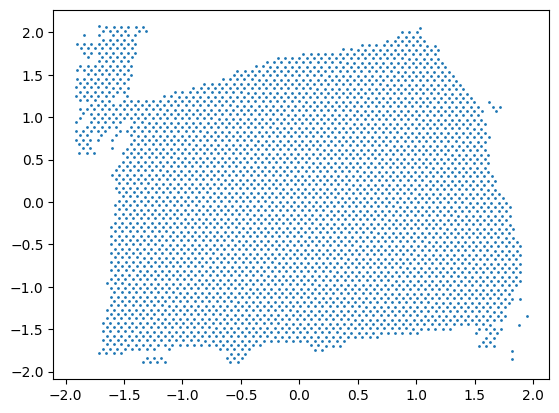

In [5]:
plt.scatter(expr_locs[:,0], expr_locs[:, 1], s = 1)

In [4]:
n = 3592 # number of locations
p = 3000 # number of genes
K = 5 # target lower dimension
m = 6 # number of neighbors to be considered for weights

##### inverse of kernel bandwidth, taken from preprocessing

In [1]:
phi = 1/0.0384389841263021

In [7]:
weights = gen_model.generate_weights(expr_locs_df, K, m, phi) ### graph information encoded by the weights

##### Cross validation

In [21]:
spl_2 = splsi.SpLSI(lamb_start = 15,
              step_size = 2.5,
              grid_len = 5,
              step= "two-step", eps = 0.01)



In [22]:
start = time.time()
spl_2.fit(expr_data, K, expr_locs_df, weights)
end = time.time()
print(end - start)

Error is 4.5759418447589225e-12
SpatialSVD ran for 1 steps for lambda = 1e-06 and fold 0.
Error is 7.398296227816502
Error is 0.7621060112228376
Error is 0.4232669361802214
Error is 0.22946045853583655
Error is 0.16077830323252656
Error is 0.14278536597659783
Error is 0.13264305089647313
Error is 0.11558897827709307
Error is 0.08680957808317426
Error is 0.05247854709323258
Error is 0.025568357174646165
Error is 0.010949717934827054
Error is 0.004578488615448474
SpatialSVD ran for 13 steps for lambda = 15.0 and fold 0.
Error is 8.112683656949608
Error is 0.533781843355867
Error is 0.37374236770975244
Error is 0.23350115662810783
Error is 0.14277385212768534
Error is 0.10753488748944472
Error is 0.0761008693958547
Error is 0.03882048227107606
Error is 0.015249612576181192
Error is 0.005344183849195433
SpatialSVD ran for 10 steps for lambda = 17.5 and fold 0.
Error is 8.463415164147838
Error is 0.3983713950837807
Error is 0.2020225319224296
Error is 0.06794876326067655
Error is 0.00058001

KeyboardInterrupt: 

#### Plotting

In [10]:
def plot_fold_cv(lamb_start, step_size, grid_len, model):
    lambd_errs = model.lambd_errs
    lambd_grid = (lamb_start + step_size*np.arange(grid_len)).tolist()
    
    lambd_grid.insert(0, 1e-06)
    cv_1 = np.round(lambd_grid[np.argmin(lambd_errs['fold_errors'][0])], 5)
    cv_2 = np.round(lambd_grid[np.argmin(lambd_errs['fold_errors'][1])], 5)
    cv_final = model.lambd
    for j, fold_errs in lambd_errs['fold_errors'].items():
        plt.plot(lambd_grid[1:],  fold_errs[1:], label=f'Fold {j}', marker = 'o')
        #plt.vlines(cv_1, 18.90, 18.25, color = "blue")
        #plt.vlines(cv_2, 18.90, 18.25, color = "orange")

    #plt.plot(lambd_grid, new_list, label='Final Errors', linestyle='--', linewidth=2)
    #plt.yscale('log')
    plt.xlabel('Lambda')
    plt.ylabel('Errors')
    plt.text(cv_1, lambd_errs['fold_errors'][0][0] -1, cv_1, color='blue')
    plt.text(cv_1, lambd_errs['fold_errors'][1][0] -1, cv_2, color='orange')
    plt.title(f'Lambda CV = {cv_final}')
    plt.legend()
    plt.show()

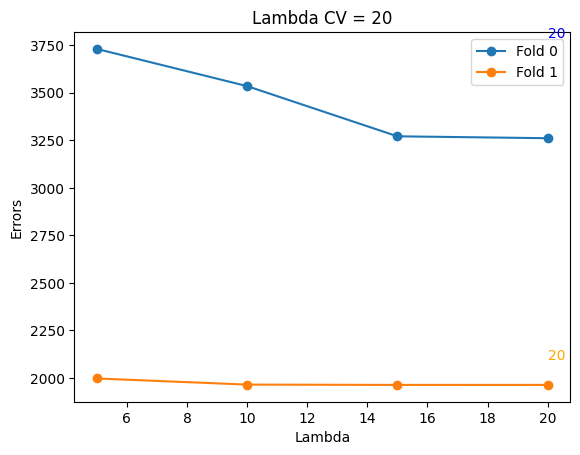

In [20]:
plot_fold_cv(15,2.5,5,model=spl_2)

##### After cross validation, use the optimal tuning parameter for iterative algorithm

In [27]:
start = time.time()
spl_2.fit2(expr_data, K, weights, lambd = 12.5)
end = time.time()
print(end - start)

Error is 9.169850976715649
Error is 0.8297347965745665
Error is 0.4419045502026596
Error is 0.31371442597858673
Error is 0.243139656068976
Error is 0.1934395519203579
Error is 0.14747630254651253
Error is 0.09514749640983555
Error is 0.055733444571480016
Error is 0.035438026169137105
Error is 0.02442022034852699
Error is 0.017703810969368575
Error is 0.013268109577019184
Error is 0.010051216781172982
Error is 0.007688563648086599
41.87903189659119


##### Output

In [28]:
U_df = pd.DataFrame(spl_2.U)
V_df = pd.DataFrame(spl_2.V)
U_df.to_csv("IP_U.csv", index = False)
V_df.to_csv("IP_V.csv", index = False)